# Introduction

This notebook exists for the exploration and analysis of canonical data collected by the [Ocean Observatories Initiative Regional Cabeled Array](https://interactiveoceans.washington.edu/). Creating a canonical record of seawater measurements is valuable in comparing data across platforms (RCA, ARGO, MODIS, GLODAP), locally and globally. The OOI RCA has multiple working stations off the Oregon coast that will be the focus of this notebook.

In order to explore data collected by the OOI RCA, we will utilize a python package called `yodapy` written by Don Setiawan at OOI. `yodapy` allows users to directly access information about the RCA and data collected by the RCA sensors. 


# Objectives

The objective of this notebook is to identify canonical values of seawater components across several years of available data at RCA sensor locations.

Overall, this includes evaluating the following:

* parameters of interest: temperature, salinity, dissolved oxygen, chlorophyll, possibly nitrate, possibly photosynthetically active radiation (par)
* depth intervals: 10 m intervals would be ideal
* time intervals: weekly averages and standard deviations would be ideal
* mean and standard deviation for each site, parameter, depth, and time
* sites:
    * 200m platforms and shallow  profilers (3 of these exist)
    * stretch goal: deep profilers (3 of these exist)

We'll begin by reducing the problem to 1 sensor, 1 parameter, 1 week, and 1 depth interval

* sensor: oregon slope base shallow profiler
* parameter: salinity
* week: aug 1-7, 2019
* 1 depth: first identify depth range available! 
* then find mean and stdev salinity for this location and time period

## Specific steps necessary to achieve the minimal objective

* choose a place to begin (see above)
* check the data availability via yodapy
    * (you can do steps 1 and 2 in opposite order if you specifically want a sensor that has good data availability)
* download data from this sensor
* open and read using netCDF4 function `Dataset('filename', 'r')`
* perform statistical analysis
* compare data over time

### A note about missing data
The RCA has limited resources and oceanic sensors are susceptible to connection issues, sensor breakages, and knock-downs that all contribute to anomalous data points or periods of missing data. For the sake of this project, time intervals that are missing a considerable amount of data (50% or more) will be marked as 'insufficient data'. 

* We need to agree on a work-around for anomalous data: how do we identify anomalies? how do we deal with them when we find them? We will cross this bridge when we get to it.

In [1]:
# install necessary packages

# Ensure that the latest build of yodapy is installed directly from github using
!pip install git+https://github.com/cormorack/yodapy.git -q     # -q cuts the stdout clutter

In [13]:
# import necessary functions

import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
import pickle

import os
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

from netCDF4 import Dataset, num2date, date2num 
from datetime import datetime, timedelta

from yodapy.datasources import OOI
ooi = OOI()

# Local application/library specific imports
from golive_library import GoliveLibrary as g

from yodapy.utils.creds import set_credentials_file

# OOI Data

Visit [OOI website](https://ooinet.oceanobservatories.org/#) to get credentials. Be sure to obscure credentials before pushing this notebook to GitHub!

Sometimes the cell below will break on you! Restart the kernel and clear all output, and get a new token from OOI. If that doesn't fix it, retry everything in this notebook or the chlorophyll notebook and hope that the error messages go away.

Included in this section are multiple commented cells that are useful commands for familiarizing yourself with the structure and extent of the RCA. Uncomment the commands in the multiple following cells to see all of the sites and instruments available for evaluation.

If you ever get a message that says "Please wait while we fetch the metadata..." it might be necessary to rerun the cell that generated the message.

The cell below tells the OOI that you have an account with them through which you can submit data requests. This will allow you to download data for use in this notebook. If you don't already have an account, you can easily create one on the [OOI website](https://ooinet.oceanobservatories.org/#).

In [3]:
# Remember to obscure your username and token when you're done!!!

# set_credentials_file(data_source='ooi', username='OOIAPI-xxxx', token='TEMP-TOKEN-xxxx')

# Recomment this line after running it once! 
# Running it twice will break your credentials! 

In [4]:
# Run these to helpful see documentation on yodapy and ooi
# help(ooi)
# help(ooi.cava_sites)

# Run this to see all commands included in yodapy
# g.dirnou(ooi)

# Run this to see all sites included in the OOI RCA cava project (cava = cabled array value added)
# print(ooi.cava_sites, '\n\n\n', ooi.cava_parameters)

# Run this to see all the components or segments of OOI available
# ooi.sites

# Run this to see all the instruments of OOI available
# ooi.instruments

## Creating the workflow

We can look at the workflow for this project as a series of steps:
* obtain desired data from OOI
* prepare data for analysis
* calculate mean and standard deviation of data bins

This section of this notebook will walk through the ways we completed each of these steps. This is our opportunity to teach others how to create a workflow for OOI RCA data analysis. After this walkthrough, these steps will be combined into a streamlined format for easier application to broader range of data. That is where we will do comparisons of the data over time.  

### Obtaining desired data from OOI


If you run any of the commands in the code cell above, you'll see that there are quite a lot of components to the RCA. With over 60 sites and 5000+ instruments, it can be difficult to identify the exact data we want. Fortunately, we are familiar with the RCA structure and terminology. Remember that you can visit the [Interactive Oceans Data Portal](https://app.interactiveoceans.washington.edu/) to learn about the site locations, instruments, parameters, and data availability for the entire RCA system.

* If we didn't know the names of sites, nodes, and instruments, where could we learn about them? Link that info here! 
* How do we see data availability on a day-by-day basis?

In [5]:
# Narrow the search using the appropriate terms.

ooi.search(region='cabled', site='oregon slope base', node='shallow', instrument='CTD')

<Data Source: OOI (1 Instrument Stream)>

,RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample
0,Cabled Continental Margin (Cabled Array)
1,Oregon Slope Base Shallow Profiler Mooring
2,Shallow Profiler (SF01A)
3,CTD
4,streamed
5,ctdpf_sbe43_sample


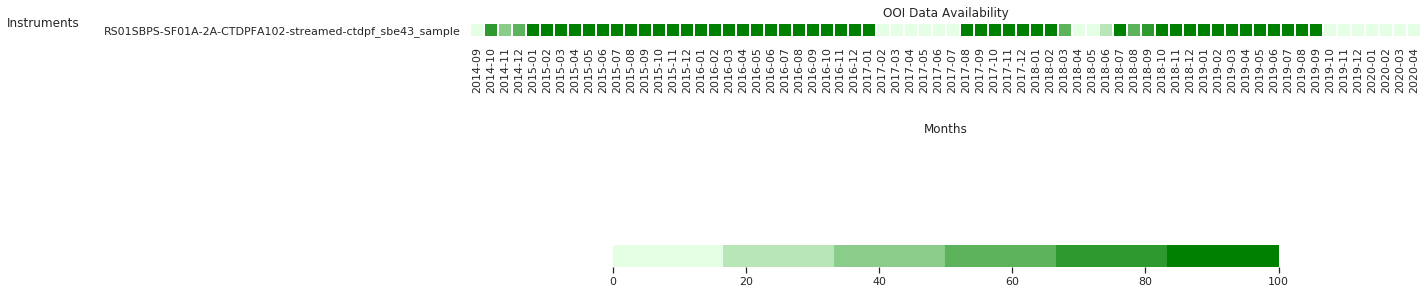

In [4]:
# Check the data availability of the selected instrument. Long periods of data may be missing.

ooi.data_availability()    # try running this cell twice if a green time plot doesn't appear on the first run

From the Interactive Oceans Data Portal we can see data availability for the CTD on the Oregon Slope Base Shallow Profiler (note that this instrument is referred to as a 'CTD-O' on the data portal because it also has an **O**xygen sensor). Below is a screenshot of the day-by-day availability of the same instrument. A more interactive version can be found on the Data Portal.

<img src="./OreSlope_ShallProf_CTD_DataAvailability.PNG">

With the desired instrument(s) selected, generate a data request to the OOI system. Recomment the following two cells after running once to avoid repeatedly requesting the same datafiles. It will benefit you to rename the downloaded file(s) to something more meaningful, such as 'site_node_instrument_####.nc' where #### = 0001, 0002, 0003 . . . 9999. 

Please note that you only need to run the request and download commands (below) once. After you request and download the data, move it into your data subdirectory (which should be outside of the working directory if you plan to push to a size limited file storage system like GitHub). Once you have your data you can comment out the request and download commands because you do not need to repeatedly request and download the same exact data file(s).

If you have already done this or just want to skip ahead, you can **skip to the section titled 'Combining the Workflow Steps'.**

In [12]:
'''Running .request_data() generates a data request
while running .to_xarray() polls the OOI system until the order completes; 
 this will take a couple of minutes'''


# Enter desired start and end dates and generate data request
#begin_date = '2019-08-01'
#end_date = '2019-08-08'    # the data file will include measurements close as possible to midnight on the morning of 2019-08-08 
#ooi.request_data(begin_date=begin_date, end_date=end_date)
#ds = ooi.to_xarray()


# Check length of new dataset list to ensure the correct number of files was requested
# len(ds)

(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 10s


Data request time elapsed: 10s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 20s


Data request time elapsed: 20s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 30s


Data request time elapsed: 30s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 41s


Data request time elapsed: 41s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 51s


Data request time elapsed: 51s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 61s


Data request time elapsed: 61s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 72s


Data request time elapsed: 72s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 82s


Data request time elapsed: 82s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 92s


Data request time elapsed: 92s


(MainThread) Request (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) completed.


Request (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200326T181133958Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) completed.


(MainThread) Acquiring data from opendap urls ...
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [13]:
# Run this to download the data (possibly multiple files) from a completed data request from above
# 
#filenamelist = ooi.download_netcdfs()
#len(filenamelist)

(MainThread) Downloading netcdfs ...
(MainThread) Downloading deployment0007_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190801T000000.066057-20190807T235959.230015.nc...
(MainThread) Writing deployment0007_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190801T000000.066057-20190807T235959.230015.nc...
(MainThread) deployment0007_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190801T000000.066057-20190807T235959.230015.nc successfully downloaded ---
(MainThread) --- Checking deployment0007_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190801T000000.066057-20190807T235959.230015.nc ---
(MainThread) --- Checks passed for deployment0007_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190801T000000.066057-20190807T235959.230015.nc ---


1

### Preparing the data for analysis

Open the downloaded dataset(s) and look at the contents. Remember that we are focusing on one dataset (Oregon Slope Base shallow profiler CTD, first week of August 2019) and one parameter (salinity) to start with. Looking through all the variables, you can find multiple entries for salinity, including: 'conductivity', 'seawater_conductivity', 'practical_salinity', 'seawater_conductivity_qc_executed', 'seawater_conductivity_qc_results' 'practical_salinity_qc_executed', and 'practical_salinity_qc_results'. 

Documentation for the netCDF4 functions used can be found [here.](https://unidata.github.io/netcdf4-python/netCDF4/index.html#netCDF4.Dataset)

By opening the dataset as an xarray dataset and not the netCDF object it exists as, we can far more easily manipulate the data and explore data across different sets. Utilizing the "swap_dims" function in xarray, we can ensure that all variables are associated with the 'time' coordinate.  That is to say, when we call the 'pressure' variable, it will automatically be associated with the 'time' coordinate and can be easily plotted along that axis.

In [3]:
home_dir = os.getenv("HOME")
this_dir = home_dir + '/eScience-Work/'
data_dir = home_dir + '/data/canon/'

In [10]:
# Open dataset in read mode

ds = xr.open_dataset(data_dir + 'OreSlope_ShallProf_CTD_2019-08-01_08-08.nc')     #Open file as xarray dataset
ds_2019 = ds.swap_dims({'obs':'time'})                          #Swap default 'obs' dimension for 'time'
depth = 'seawater_pressure'

The CTD lists 3 variable for conductivity/salinity.  By printing the listing for these variables, we can see that the "practical_salinity" variable most closely matches what we want to explore.

In [11]:
# print(ds.variables['conductivity'])
# print('\n')

# print(ds.variables['seawater_conductivity'])
# print('\n')

print(ds_2019.variables['practical_salinity'])
print('\n')
print(type(ds_2019))

<xarray.Variable (time: 598189)>
[598189 values with dtype=float64]
Attributes:
    comment:                  Salinity is generally defined as the concentrat...
    long_name:                Practical Salinity
    precision:                4
    data_product_identifier:  PRACSAL_L2
    standard_name:            sea_water_practical_salinity
    units:                    1
    ancillary_variables:      pressure,conductivity,temperature


<class 'xarray.core.dataset.Dataset'>


In [14]:
out_fn = data_dir + 'pickled_array.p'
pickle.dump(ds_2019, open(out_fn, 'wb'))

Now we can take a look at the raw data by plotting the practical salininty vs. seawater pressure. Below that, we can also create a time series plot of this data. The time series plot shows the 9 daily trips up and down the water column that the shallow profiler makes, reflected in changes in the salinity. 
* make this a scatter plot instead of line plot

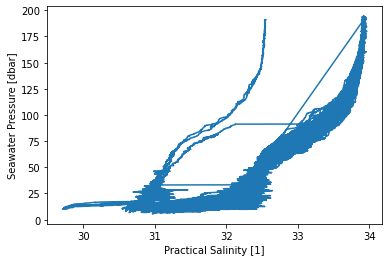

In [6]:
ds_2019.practical_salinity.plot(y = depth) 

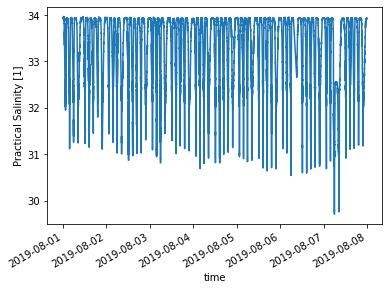

In [7]:
ds_2019.practical_salinity.plot()

We can already begin thinking about interpretting data, even just based off this singular week from the CTD. That look salinity spike could indicate rainy weather or an increase in river runoff. How interesting! 

The last steps in preparing our data for analysis is to bin it according to our desired depth intervals and then select data for the parameter we are interested in (practical salinity). At this point, running `ds_bin.mean()` takes a long time because it finds the mean of every variable in the dataset. Separating the practical salinity from the rest of the data speeds up our mean calculation considerably. 
* need to change this from 20 bins of equal size to bins by specified 10m depth intervals

In [11]:
# Separate the practical salinity from the rest of the data
dsps = ds_2019.practical_salinity

# Now confirm that this dataarray has what we want
dsps

<xarray.DataArray 'practical_salinity' (time: 598189)>
[598189 values with dtype=float64]
Coordinates:
    obs                (time) int32 0 1 2 3 4 ... 598185 598186 598187 598188
  * time               (time) datetime64[ns] 2019-08-01T00:00:00.066056704 ... 2019-08-07T23:59:59.230014976
    seawater_pressure  (time) float64 ...
    lat                (time) float64 ...
    lon                (time) float64 ...
Attributes:
    comment:                  Salinity is generally defined as the concentrat...
    long_name:                Practical Salinity
    precision:                4
    data_product_identifier:  PRACSAL_L2
    standard_name:            sea_water_practical_salinity
    units:                    1
    ancillary_variables:      pressure,conductivity,temperature

In [12]:
# Group the practical salinity data by depth bins
# bins = 20 means we're breaking our data up into 20 bins of equal size
# as in each group will cover an equal range of depths

dsps_bin = dsps.groupby_bins(group = depth, bins = 20)

dsps_bin

### Analysing the data

Now that we've got the data for our parameter isolated and split into bins of about 10m depth intervals, we can use built-in functions to calculate the mean and standard deviation for practical salinity. The `.mean()` and `.std()` functions may take a minute to run. 

* cannot seem to get the seawater pressure to be on the y axis, I get an error every time I set y='seawater_pressure_bins'
* change 'practical_salinity' axes to 'mean' and 'standard deviation'

In [13]:
# Let's get a variable that has the means of practical salinity for each depth bin
dsps_mean = dsps_bin.mean()
type(dsps_mean)

# We also want the standard deviation
dsps_stdev = dsps_bin.std()
type(dsps_stdev)

xarray.core.dataarray.DataArray

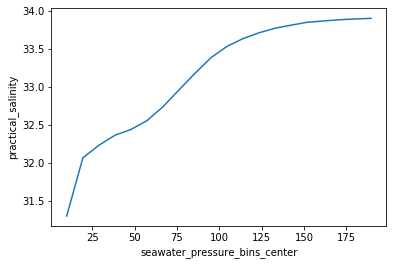

In [14]:
# Plot the mean to see how practical salinity changes with depth

dsps_mean.plot(x='seawater_pressure_bins')

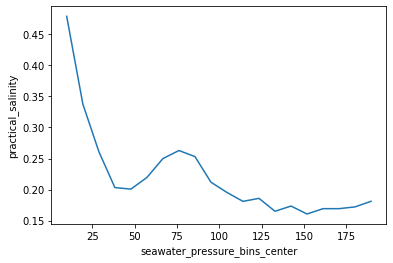

In [15]:
# We can also plot standard deviation and see how it changes with depth

dsps_stdev.plot()

In [16]:
# View the DataArray holding our mean data

dsps_mean_2019 = dsps_mean

In [17]:
# View the DataArray holding our standard deviation data

dsps_stdev_2019 = dsps_stdev

## What we've done so far

* pulled in salinity data from Oregon Slope shallow profiler for the first week of August 2019
* turned data into an xarray dataarray along the 'time' dimension
* identified 'practical_salinity' as our desired variable
* plotted salinity measurements vs. depth ('seawater_pressure') (would be cool if this could be a scatter plot)
* plotted salinity as a time series (can we combine with the depth profile to make a 2D color plot?)
* grouped salinity measurements by depth bins (20 bins of equal size)
* calculated and plotted mean and standard deviation of the binned salinity data

## What to do next

* combine the binning, stats, and plotting commands into one function that can be applied to any dataset 
* pull in data from the first week of August 2018 and compare this with the same dates in 2019
* pull in data from other weeks of 2018 and 2019 and do the same comparison

### Comparing August 2019 to August 2018, 2017, and so on

Now that we have established a mean and standard deviation for the first week of August 2019, let's do the same thing for the first week of August of previous years. Then we can begin to see what canonical values of practical salinity are for this time of year at this location. The cells below are a streamlined version of the steps that we worked through one-by-one above. 

In [18]:
%%time
'''Running .request_data() generates a data request
while running .to_xarray() polls the OOI system until the order completes; 
 this will take a couple of minutes'''

# Enter desired start and end dates and generate data request
#begin_date = '2018-08-01'
#end_date = '2018-08-08'
#ooi.request_data(begin_date=begin_date, end_date=end_date)
#ds = ooi.to_xarray()


# Check length of new dataset list to ensure the correct number of files was requested
# len(ds)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


'Running .request_data() generates a data request\nwhile running .to_xarray() polls the OOI system until the order completes; \n this will take a couple of minutes'

In [19]:
# Run this to download the data (possibly multiple files) from a completed data request from above
# 
#filenamelist = ooi.download_netcdfs()
#len(filenamelist)

In [20]:
# Open dataset in read mode

ds = xr.open_dataset(data_dir + 'OreSlope_ShallProf_CTD_2018-08-01_08-08.nc')     #Open file as xarray dataset
ds_2018 = ds.swap_dims({'obs':'time'})                          #Swap default 'obs' dimension for 'time'
depth = 'seawater_pressure'

In [21]:
x = ds_2018.seawater_pressure

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  """


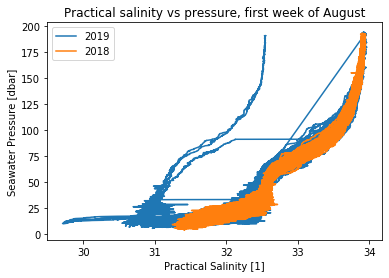

In [28]:
ds_2019.practical_salinity.plot(y = depth, label=2019)
ds_2018.practical_salinity.plot(y = depth, label=2018) 
plt.legend()
plt.title('Practical salinity vs pressure, first week of August')

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys


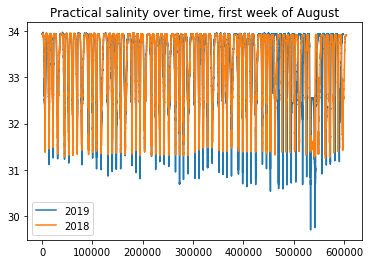

In [29]:
# This plot needs the x-axis labels to be changed from seconds to dates 08-01 to 08-08

plt.plot(ds_2019.practical_salinity, label=2019) 
plt.plot(ds_2018.practical_salinity, label=2018) 
plt.legend()
plt.title('Practical salinity over time, first week of August')

In [24]:
dsps = ds.practical_salinity
dsps_bin = dsps.groupby_bins(group = depth, bins = 20)

In [25]:
# Let's get a variable that has the means of practical salinity for each depth bin
dsps_mean_2018 = dsps_bin.mean()

# We also want the standard deviation
dsps_stdev_2018 = dsps_bin.std()

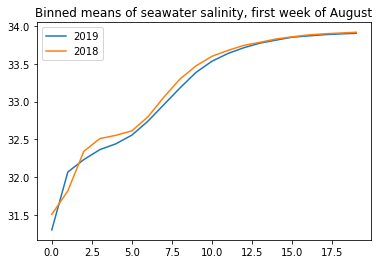

In [30]:
plt.plot(dsps_mean_2019, label="2019")
plt.plot(dsps_mean_2018, label="2018")
plt.legend()
plt.title('Binned means of seawater salinity, first week of August')

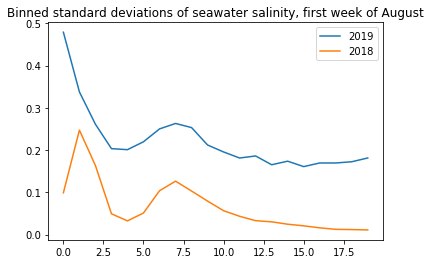

In [31]:
plt.plot(dsps_stdev_2019, label="2019")
plt.plot(dsps_stdev_2018, label="2018")
plt.legend()
plt.title('Binned standard deviations of seawater salinity, first week of August')

In [38]:
ds_2019.practical_salinity

<xarray.DataArray 'practical_salinity' (time: 598189)>
array([33.935033, 33.934455, 33.934221, ..., 33.923497, 33.923497, 33.923366])
Coordinates:
    obs                (time) int32 0 1 2 3 4 ... 598185 598186 598187 598188
  * time               (time) datetime64[ns] 2019-08-01T00:00:00.066056704 ... 2019-08-07T23:59:59.230014976
    seawater_pressure  (time) float64 191.4 191.4 191.4 ... 194.2 194.2 194.2
    lat                (time) float64 ...
    lon                (time) float64 ...
Attributes:
    comment:                  Salinity is generally defined as the concentrat...
    long_name:                Practical Salinity
    precision:                4
    data_product_identifier:  PRACSAL_L2
    standard_name:            sea_water_practical_salinity
    units:                    1
    ancillary_variables:      pressure,conductivity,temperature

ValueError: Unrecognized character e in format string

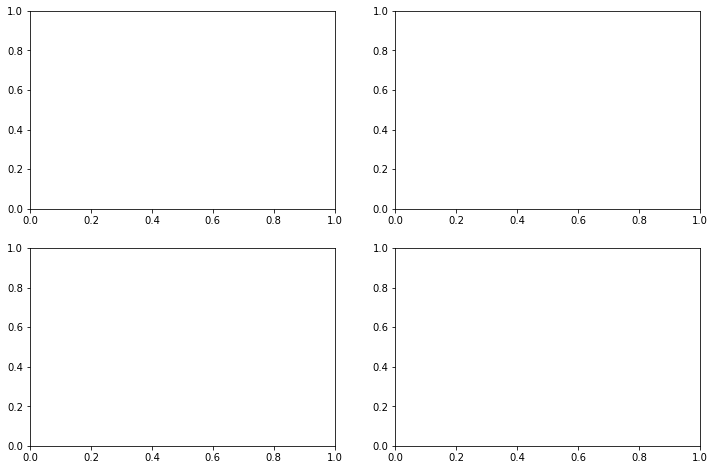

In [36]:
NR = 2; NC = 2
y = depth
x = ds_2019.practical_salinity
fig, axes = plt.subplots(nrows=NR, ncols=NC, figsize=(12,8), squeeze=False)
axes[0,0].plot(x,y)
#axes[0,1].plot(x,y)
#axes[1,0].plot(x,y3)
#axes[1,1].plot(x,y4)
fig.suptitle(tstr) # add a title over all the plots

Text(0.5, 1.0, 'Binned standard deviations of seawater salinity, first week of August')

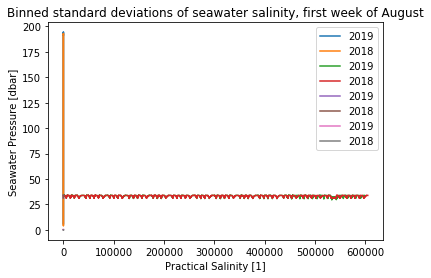

In [34]:
x1 = ds_2019.practical_salinity
ds_2018.practical_salinity.plot(y = depth, label=2018) 
plt.legend()
plt.title('Practical salinity vs pressure, first week of August')

# This plot needs the x-axis labels to be changed from seconds to dates 08-01 to 08-08

plt.plot(ds_2019.practical_salinity, label=2019) 
plt.plot(ds_2018.practical_salinity, label=2018) 
plt.legend()
plt.title('Practical salinity over time, first week of August')

dsps = ds.practical_salinity
dsps_bin = dsps.groupby_bins(group = depth, bins = 20)

# Let's get a variable that has the means of practical salinity for each depth bin
dsps_mean_2018 = dsps_bin.mean()

# We also want the standard deviation
dsps_stdev_2018 = dsps_bin.std()

plt.plot(dsps_mean_2019, label="2019")
plt.plot(dsps_mean_2018, label="2018")
plt.legend()
plt.title('Binned means of seawater salinity, first week of August')

plt.plot(dsps_stdev_2019, label="2019")
plt.plot(dsps_stdev_2018, label="2018")
plt.legend()
plt.title('Binned standard deviations of seawater salinity, first week of August')

# Pick up from here

Next: compare the first week of August 2019 to 2018. 
To really improve the current state of this notebook, set it up to cycle through these different times using one large function and plot multiple time periods on one plot. Rely on Rob's chlorophyll notebook for direction! 

## Combining the Workflow Steps

Now that we've done each step one-by-one, we can combine the steps explained above into a streamlined process. This section will include the following:
* download dataset for the shallow profiler at oregon slope base for the year 2019 (be sure you entered your credentials way above)
* open dataset and swap dims
* analyze data on a weekly time interval
* obtain the means and stdevs for the weekly time intervals
* plot together to see how mean and stdev of practical salinity changes throughout the year

In [8]:
'''Running .request_data() generates a data request
while running .to_xarray() polls the OOI system until the order completes; 
 this will take a couple of minutes'''


# Enter desired start and end dates and generate data request
#begin_date = '2019-01-01'
#end_date = '2019-12-31'
#ooi.request_data(begin_date=begin_date, end_date=end_date)
#ds = ooi.to_xarray()


# Check length of new dataset list to ensure the correct number of files was requested
# len(ds)

(MainThread) RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample time check - End time exceeds stream endTime
(MainThread) Setting request end time to stream endTime
(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 10s


Data request time elapsed: 10s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 20s


Data request time elapsed: 20s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 30s


Data request time elapsed: 30s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 41s


Data request time elapsed: 41s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 51s


Data request time elapsed: 51s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 61s


Data request time elapsed: 61s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 72s


Data request time elapsed: 72s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 82s


Data request time elapsed: 82s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 92s


Data request time elapsed: 92s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 103s


Data request time elapsed: 103s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 113s


Data request time elapsed: 113s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 123s


Data request time elapsed: 123s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 133s


Data request time elapsed: 133s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 144s


Data request time elapsed: 144s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 159s


Data request time elapsed: 159s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 170s


Data request time elapsed: 170s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 180s


Data request time elapsed: 180s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 190s


Data request time elapsed: 190s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 201s


Data request time elapsed: 201s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 211s


Data request time elapsed: 211s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 221s


Data request time elapsed: 221s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 232s


Data request time elapsed: 232s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 242s


Data request time elapsed: 242s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 252s


Data request time elapsed: 252s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 263s


Data request time elapsed: 263s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 273s


Data request time elapsed: 273s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 283s


Data request time elapsed: 283s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 294s


Data request time elapsed: 294s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 304s


Data request time elapsed: 304s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 314s


Data request time elapsed: 314s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 325s


Data request time elapsed: 325s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 335s


Data request time elapsed: 335s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 345s


Data request time elapsed: 345s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 356s


Data request time elapsed: 356s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 366s


Data request time elapsed: 366s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 376s


Data request time elapsed: 376s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 387s


Data request time elapsed: 387s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 397s


Data request time elapsed: 397s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) is still compiling... Please wait.


(MainThread) Data request time elapsed: 407s


Data request time elapsed: 407s


(MainThread) Request (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) completed.


Request (https://opendap.oceanobservatories.org/async_results/deryag@uw.edu/20200324T170443074Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample) completed.


(MainThread) Acquiring data from opendap urls ...
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [9]:
# Run this to download the data (possibly multiple files) from a completed data request from above
# 
filenamelist = ooi.download_netcdfs()
len(filenamelist)

(MainThread) Downloading netcdfs ...
(MainThread) Downloading deployment0006_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190101T000000.743189-20190320T235959.267689.nc...
(MainThread) Writing deployment0006_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190101T000000.743189-20190320T235959.267689.nc...
(MainThread) deployment0006_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190101T000000.743189-20190320T235959.267689.nc successfully downloaded ---
(MainThread) --- Checking deployment0006_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190101T000000.743189-20190320T235959.267689.nc ---
(MainThread) --- Checks passed for deployment0006_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190101T000000.743189-20190320T235959.267689.nc ---
(MainThread) Downloading deployment0006_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20190321T000000.267597-20190608T235959.068926.nc...
(MainThread) Writing deployment0006_RS01SBPS-SF01A-2A

5

In [18]:
# Open dataset in read mode (dataset should be renamed after download)

ds = xr.open_dataset('OreSlope_ShallProf_CTD_2019_09-07.nc')     #Open file as xarray dataset
ds = ds.swap_dims({'obs':'time'})                          #Swap default 'obs' dimension for 'time'
depth = 'seawater_pressure'

In [19]:
ds

<xarray.Dataset>
Dimensions:                                 (time: 1740330)
Coordinates:
    obs                                     (time) int32 0 1 ... 1740328 1740329
  * time                                    (time) datetime64[ns] 2019-09-07T00:00:00.416410112 ... 2019-09-27T18:41:52.175124992
    seawater_pressure                       (time) float64 ...
    lat                                     (time) float64 ...
    lon                                     (time) float64 ...
Data variables:
    deployment                              (time) int32 ...
    id                                      (time) |S36 ...
    conductivity                            (time) float64 ...
    driver_timestamp                        (time) datetime64[ns] ...
    ext_volt0                               (time) float64 ...
    ingestion_timestamp                     (time) datetime64[ns] ...
    internal_timestamp                      (time) datetime64[ns] ...
    port_timestamp                   

In [ ]:
for monthstring in ['01', '02', '03', '04', '05', '06', '07', '08', '09']:
    for daystring in ['01', '15']:
        datestring0 = '2019-' + monthstring + '-' + daystring + 'T08:30' 
        datestring1 = '2019-' + monthstring + '-' + daystring + 'T11:50' 
        ds1 = ds_mean.sel(time=slice(datestring0, datestring1))